# k-Nearest Neighbours

In this notebook we will implement a classifier based on the k-NN techinique described in the report file. These are the libraries used throughout the notebook.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In this section we define some global variables that will be used in the rest of the notebook. Specifically: 
* genre_names: contains all the genres included in the data set
* data: contains the DataFrame on which the data are exported
* data_normalized: contains the DataFrame normalized

In [2]:
genre_names = ['blues', 'classical', 'country', 'disco', 'hipop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

#test_dataset is the .csv created in the feature_extraction function
data = pd.read_csv('./test_dataset.csv')

#normalization of the data set
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

# **Division between Train Set and Test Set**
This piece of code has the purpose to divide the data_normalized in two sets: one will be used by the classifier to find the genre that is more suitable for the input gave, and the other will be used to make some analysis on how well does the classifier works.

In [3]:
#Indexes extraction
indexes_train = np.random.choice(1000, 800, replace=False)
indexes_valid= np.setdiff1d(np.array([i for i in range(1000)]), indexes_train)

#Deleting the row Unamed
data_normalized_test = np.array([data_normalized['ZCR'], data_normalized['AVERAGE_ENERGY'], data_normalized['SILENT_RATIO'], data['CLASS']])

#Division of the two sets
data_normalized_train = data_normalized_test[0:4, indexes_train]
data_normalized_valid = data_normalized_test[0:4, indexes_valid]

# **Data visualization**

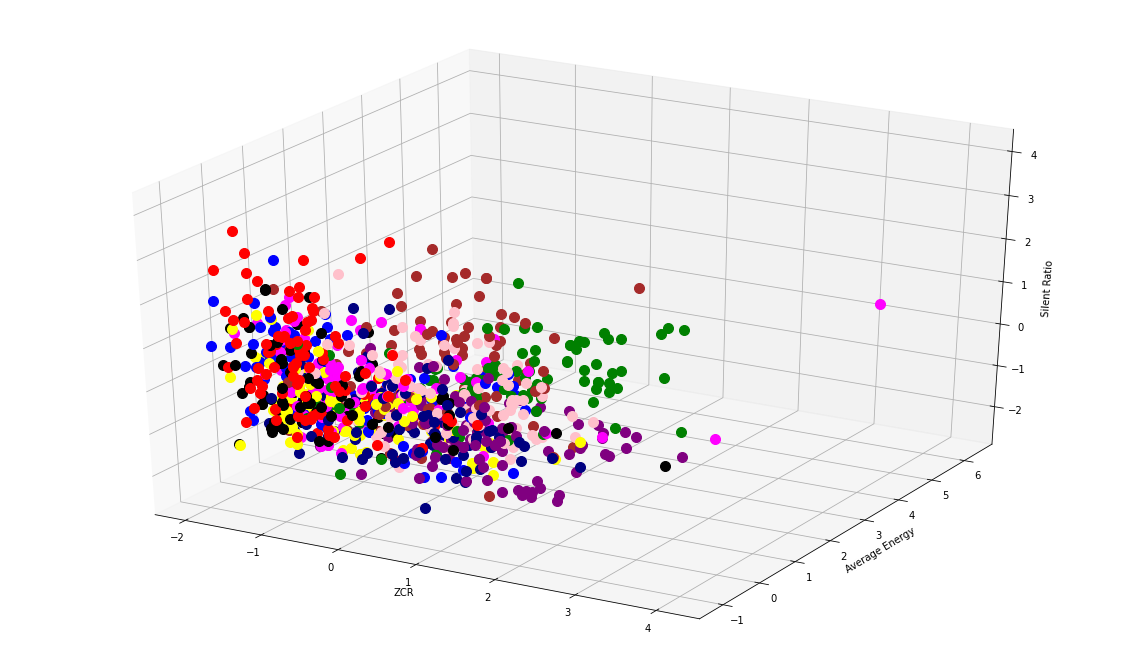

In [31]:
# Creating a 3d plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
colors = ['blue', 'red', 'yellow', 'pink', 'brown', 'black', 'purple', 'green', 'magenta', 'navy']

#Iterating on the genres
for i in range(len(genre_names)):
  #Iterating on the features of the genres
  for j in range(100):
    ax.scatter(data_normalized_test[0, (100*i)+j], data_normalized_test[1, (100*i)+j], data_normalized_test[2, (100*i)+j], label = genre_names[i], c=colors[i], s = 100)

ax.set_xlabel('ZCR')
ax.set_ylabel('Average Energy')
ax.set_zlabel('Silent Ratio')

fig.show()

# **Classifier**
Here there is the code that implements the k-NN classifier. It takes as input:


*   Input: a three dimensional vector that contains the features of the sound that we want to classify
*   Genres to classify: a list that expresses which genres we want to check with respect to the input gave
* k: number of the saved distances that we want to keep in memory
* distace: the function to used in order to calculate the distance




In [21]:
def kNN(input, genres_to_classify=genre_names, k=1, distance= np.linalg.norm):
  #Inizialization:
  ##min_dist: this numpy array contains the minimum distances found in the program in increasing order
  ##class_dist: this numpy array contains the class associated to the distances saved in min_dist
  ##class_counter: this numpy array will be used at the end of the code to count how many times a genres is found between the minimum distances
  min_dist = np.array([2125262800.0 for i in range(k)])
  class_dist = np.array([-1.0 for i in range(k)])
  class_counter = np.array([0.0 for i in range(10)])

  #Iterating on the genres gave as input
  for genre_name in genres_to_classify:
    #Keeping the number value of the genre currently considered
    class_curr= genre_names.index(genre_name)

    #Here we extract the features of the training set that belong to the genre previously calculated
    #(the field class is then removed)
    analizying = data_normalized_train[0:4, data_normalized_train[3, :] == class_curr]
    analizying_data = analizying[0:3]

    #Iterating on the data of the training set of the genre considered
    for i in range(analizying_data.shape[0]):
      #Calculating the distance of the training set's data from the input.
      curr_dist = distance(input - analizying_data[:, i])

      #If the distance found is minor than the maximum distance stored, it should be inserted in the min_dist array
      if curr_dist < np.max(min_dist):
        #Ranging inside the min_dist array to inserted the value
        for j in range(k):
          #If a value bigger than the distance currently considered is found, it means that the distance must go before that value.
          if min_dist[j]>curr_dist:
            #Inserting the value in the right place and cutting the min_dist array.
            min_dist= np.insert(min_dist, j, curr_dist) 
            class_dist= np.insert(class_dist, j, class_curr)
            min_dist= min_dist[0:k]
            class_dist=class_dist[0:k]
            print(min_dist)
            break
            
  #If the k distances that we have to store are more than one we should count the genres found, otherwise the result is immediately
  #calculated
  if k>1:
    result_counter=0
    last_found=np.array([])

    #Iterating on the class_dist array
    for i in range(k):
      #For each saved genre of class_dist array the class counter is incremented
      class_counter[class_dist[i].astype(int)] = class_counter[class_dist[i].astype(int)] + 1

    #Iterating on class_counter
    for i in range(10):
      #This control is needed to check if there are more classes with the same number of nearest points
      if (class_counter[i]==np.max(class_counter)):
        result_counter +=1
        last_found= np.append(last_found, i)
    
    #If more genres have the same number of nearest points, the nearest genre is considered, else the genre with maximum number of near 
    #points is returned
    if result_counter>1:
      #Iterating on class_dist
      for ii in range(k):
        #Iterating on last_found
        for jj in range(last_found.size):
          #First nearest genre found
          if last_found[jj] == class_dist[ii]:
            return genre_names[class_dist[ii].astype(int)]
    else:
      return genre_names[last_found[0].astype(int)]

  else:
    return genre_names[int(class_dist)]

# **Tests**
In the following part of the notebook many tests are made to analyzing the behaviour of the classifier when the inputs are changed. More genres, ks and distances are considered. In particular the ks are always: 1, 3, 5, 7, 9.

# **Confusion matrix: 2 genres, Euclidean distance**

In [8]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['classical', 'pop']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} ks and 2 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 ks and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 20.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.8571428571428571

Printing confusion matrix for 3 ks and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0. 17.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.

# **Confusion matrix: 6 genres, Euclidean distance**

In [9]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['blues', 'classical', 'country', 'disco', 'pop', 'rock']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 6 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 6 genres
[[ 8.  8.  2.  2.  0.  0.  0.  4.  0.  2.]
 [ 0.  7.  0.  4.  0.  0.  0.  3.  0.  0.]
 [ 3.  8.  2.  2.  0.  0.  0.  5.  0.  1.]
 [ 1.  2.  1.  3.  0.  0.  0.  4.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  0.  0.  1.  0.  0.  0. 15.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  6.  0.  0.  0.  4.  0.  6.]]
Accurancy 0.3504273504273504

Printing confusion matrix for 3 k and 6 genres
[[ 7.  8.  4.  0.  0.  0.  0.  3.  0.  4.]
 [ 0.  7.  0.  3.  0.  0.  0.  3.  0.  1.]
 [ 2.  8.  3.  1.  0.  0.  0.  5.  0.  2.]
 [ 2.  2.  1.  4.  0.  0.  0.  4.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  0.  1.  2.  0.  0.  0. 10.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  2.  0.  0.  0.  4.  0. 10.]]
Accurancy 0.35

# **Confusion matrix: 10 genres, Euclidean distance**

In [13]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = genre_names

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 10 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 10 genres
[[2. 7. 1. 2. 1. 5. 4. 1. 1. 2.]
 [0. 7. 0. 3. 0. 3. 0. 0. 1. 0.]
 [3. 8. 0. 2. 1. 3. 0. 3. 0. 1.]
 [1. 2. 1. 2. 0. 0. 3. 1. 2. 2.]
 [6. 1. 1. 4. 0. 0. 2. 0. 1. 1.]
 [0. 8. 0. 3. 0. 4. 0. 1. 2. 0.]
 [0. 0. 4. 2. 0. 0. 8. 1. 2. 8.]
 [2. 0. 0. 0. 1. 0. 4. 7. 5. 2.]
 [1. 6. 1. 2. 0. 1. 1. 4. 7. 1.]
 [0. 1. 3. 6. 1. 0. 0. 3. 2. 5.]]
Accurancy 0.21

Printing confusion matrix for 3 k and 10 genres
[[1. 7. 2. 1. 1. 5. 4. 1. 1. 3.]
 [0. 7. 0. 3. 0. 3. 0. 0. 1. 0.]
 [3. 8. 0. 1. 1. 3. 0. 3. 0. 2.]
 [1. 2. 1. 3. 0. 0. 3. 1. 2. 1.]
 [5. 1. 1. 3. 2. 0. 1. 0. 1. 2.]
 [0. 7. 0. 3. 0. 5. 0. 1. 2. 0.]
 [0. 0. 4. 4. 0. 0. 8. 1. 2. 6.]
 [2. 0. 1. 0. 3. 0. 2. 6. 5. 2.]
 [1. 7. 1. 0. 1. 1. 0. 4. 7. 2.]
 [0. 1. 3. 2. 1. 0. 0. 3. 2. 9.]]
Accurancy 0.24

Printing confusion matrix for 5 k and 10 genres
[[ 2.  7.  4.  0.  1.  3.  5.  1.  0.  3.]
 [ 0.  5.  0.  4.  0.  4.  0.  0.  0.  1.]
 [ 2.  6.  1.  1.  1.  5.  0.  3.  0.  2.]
 [ 2.  2.  1.  4.  0.  0.  2.  1.

# **Other distance functions used**
In addition, other distances were included, in particular: Manhattan Distance and Chebyshev Distance.

## *Manhattan Distance*

$d(x, y) = \sum_i{|x_i - y_i|}$

### **Confusion matrix: 2 genres, Manhattan distance**

In [14]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['classical', 'pop']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
manhattan_distance = lambda x : np.sum(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 2 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=manhattan_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 20.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.8571428571428571

Printing confusion matrix for 3 k and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0. 17.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.77

### **Confusion matrix: 6 genres, Manhattan distance**

In [15]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['blues', 'classical', 'country', 'disco', 'pop', 'rock']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
manhattan_distance = lambda x : np.sum(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 6 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=manhattan_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 6 genres
[[ 8.  8.  1.  2.  0.  0.  0.  4.  0.  3.]
 [ 0.  7.  0.  3.  0.  0.  0.  3.  0.  1.]
 [ 4.  7.  1.  2.  0.  0.  0.  6.  0.  1.]
 [ 1.  2.  2.  3.  0.  0.  0.  3.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  1.  2.  0.  0.  0. 12.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  5.  0.  0.  0.  4.  0.  7.]]
Accurancy 0.3247863247863248

Printing confusion matrix for 3 k and 6 genres
[[ 5.  8.  5.  0.  0.  0.  0.  3.  0.  5.]
 [ 0.  7.  0.  3.  0.  0.  0.  3.  0.  1.]
 [ 3.  7.  2.  1.  0.  0.  0.  6.  0.  2.]
 [ 1.  2.  2.  3.  0.  0.  0.  3.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  1.  1.  0.  0.  0. 12.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  3.  0.  0.  0.  4.  0.  9.]]
Accurancy 0.32

### **Confusion matrix: 10 genres, Manhattan distance**

In [16]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = genre_names

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
manhattan_distance = lambda x : np.sum(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 10 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=manhattan_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 10 genres
[[2. 6. 1. 2. 1. 5. 3. 1. 3. 2.]
 [0. 7. 0. 2. 0. 3. 0. 0. 1. 1.]
 [3. 7. 0. 2. 1. 3. 0. 4. 0. 1.]
 [1. 2. 2. 2. 0. 0. 2. 0. 3. 2.]
 [7. 1. 1. 3. 1. 0. 1. 1. 0. 1.]
 [0. 8. 0. 2. 0. 4. 0. 1. 2. 1.]
 [0. 0. 4. 1. 1. 0. 8. 2. 1. 8.]
 [2. 0. 1. 0. 3. 0. 4. 1. 8. 2.]
 [1. 6. 1. 3. 1. 1. 0. 4. 6. 1.]
 [0. 1. 3. 5. 2. 0. 0. 3. 1. 6.]]
Accurancy 0.185

Printing confusion matrix for 3 k and 10 genres
[[2. 6. 1. 2. 1. 5. 3. 1. 3. 2.]
 [0. 6. 0. 3. 0. 4. 0. 0. 1. 0.]
 [3. 7. 0. 2. 1. 3. 0. 4. 0. 1.]
 [1. 2. 2. 2. 0. 0. 2. 0. 3. 2.]
 [6. 1. 2. 2. 2. 0. 1. 0. 0. 2.]
 [0. 7. 0. 2. 0. 5. 0. 1. 2. 1.]
 [0. 0. 4. 3. 1. 0. 8. 2. 1. 6.]
 [2. 0. 1. 0. 3. 0. 4. 1. 8. 2.]
 [1. 6. 1. 2. 1. 1. 0. 4. 6. 2.]
 [0. 1. 3. 3. 2. 0. 0. 3. 1. 8.]]
Accurancy 0.2

Printing confusion matrix for 5 k and 10 genres
[[ 2.  6.  5.  0.  1.  3.  4.  0.  2.  3.]
 [ 0.  6.  0.  2.  0.  4.  0.  0.  0.  2.]
 [ 2.  6.  1.  1.  1.  6.  0.  2.  0.  2.]
 [ 1.  1.  1.  3.  1.  1.  2.  0.

## *Chebyshev Distance*

$d(x, y) = \max_i{|x_i - y_i|}$

### **Confusion matrix: 2 genres, Chebyshev distance**

In [17]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['classical', 'pop']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
chebyshev_distance = lambda x : np.max(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 2 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=chebyshev_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 21.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.8857142857142857

Printing confusion matrix for 3 k and 2 genres
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  9.  0.  0.  0.  0.  0.  5.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0. 13.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Accurancy 0.62

### **Confusion matrix: 6 genres, Chebyshev distance**

In [18]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = ['blues', 'classical', 'country', 'disco', 'pop', 'rock']

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
chebyshev_distance = lambda x : np.max(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 6 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=chebyshev_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 6 genres
[[ 4.  8.  2.  2.  0.  0.  0.  9.  0.  1.]
 [ 0.  6.  0.  4.  0.  0.  0.  3.  0.  1.]
 [ 3.  8.  1.  3.  0.  0.  0.  5.  0.  1.]
 [ 2.  2.  3.  2.  0.  0.  0.  2.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  0.  0.  2.  0.  0.  0. 11.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  5.  0.  0.  0.  5.  0.  6.]]
Accurancy 0.2564102564102564

Printing confusion matrix for 3 k and 6 genres
[[2. 6. 4. 0. 0. 0. 0. 9. 0. 5.]
 [0. 6. 1. 4. 0. 0. 0. 2. 0. 1.]
 [2. 7. 4. 2. 0. 0. 0. 3. 0. 3.]
 [2. 2. 2. 3. 0. 0. 0. 3. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 1. 2. 0. 0. 0. 8. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 3. 3. 0. 0. 0. 4. 0. 9.]]
Accurancy 0.27350427350427353

Printing confusion matrix for 5 k and 6 genres
[[2. 6. 7. 0. 0. 0. 0. 5. 0. 6.]
 [0

### **Confusion matrix: 10 genres, Chebyshev distance**

In [19]:
#Inizialization
confusion_matrix = np.zeros((10, 10))
k_tested = np.array([1, 3, 5, 7, 9])
genres_tested = genre_names

genre_indices = list()

#Extrancting the indices of the genres presented
for genre_n in genres_tested: 
  genre_indices.append(genre_names.index(genre_n))

#Creating a mask that extracts the features of the validation set with the genres wanted
test_set_filter = np.zeros(data_normalized_valid.shape[1], dtype='bool')
for j in range(data_normalized_valid.shape[1]): 
  test_set_filter[j] = data_normalized_valid[3, j] in genre_indices
data_normalized_valid_tested = data_normalized_valid[0:4, test_set_filter]

#Defined distance
chebyshev_distance = lambda x : np.max(np.abs(x))

#Iterating on the ks
for k_curr in k_tested:
  print("Printing confusion matrix for {} k and 10 genres".format(k_curr))

  #Iterating on the validation data extracted
  for i in range(data_normalized_valid_tested.shape[1]):
    #True genre of the value
    current_class = data_normalized_valid_tested[3, i]

    #Predicted genre of the value in text form
    predicted_class = kNN(data_normalized_valid_tested[0:3, i], genres_to_classify=genres_tested, k=k_curr, distance=chebyshev_distance)

    #Updating the confusion matrix
    confusion_matrix[int(current_class), genre_names.index(predicted_class)] = confusion_matrix[int(current_class), genre_names.index(predicted_class)] + 1

  #Printing the confusion matrix found for this case and the accuracy calculated
  print(confusion_matrix)
  print("Accurancy {}".format(confusion_matrix.trace()/confusion_matrix.sum()))
  print()

  #Reinitialization
  confusion_matrix = np.zeros((10, 10))

Printing confusion matrix for 1 k and 10 genres
[[4. 8. 0. 2. 1. 4. 4. 2. 0. 1.]
 [0. 6. 0. 4. 0. 2. 0. 1. 0. 1.]
 [2. 8. 0. 2. 0. 3. 1. 2. 2. 1.]
 [1. 2. 2. 1. 1. 0. 2. 1. 1. 3.]
 [5. 1. 0. 3. 1. 0. 2. 1. 2. 1.]
 [0. 7. 0. 3. 0. 4. 0. 2. 2. 0.]
 [1. 0. 3. 2. 0. 0. 8. 1. 2. 8.]
 [1. 0. 0. 1. 2. 0. 3. 8. 4. 2.]
 [1. 5. 1. 3. 0. 1. 1. 5. 6. 1.]
 [0. 1. 3. 5. 1. 0. 0. 4. 2. 5.]]
Accurancy 0.215

Printing confusion matrix for 3 k and 10 genres
[[2. 8. 3. 1. 1. 3. 4. 2. 0. 2.]
 [0. 6. 0. 4. 0. 3. 0. 0. 0. 1.]
 [2. 8. 1. 2. 0. 2. 1. 2. 2. 1.]
 [1. 2. 2. 3. 1. 0. 1. 1. 1. 2.]
 [5. 1. 0. 3. 2. 0. 1. 1. 2. 1.]
 [0. 7. 0. 2. 0. 4. 0. 2. 2. 1.]
 [1. 0. 2. 5. 0. 0. 7. 1. 2. 7.]
 [1. 0. 0. 1. 4. 0. 1. 8. 4. 2.]
 [1. 7. 1. 0. 1. 1. 0. 5. 6. 2.]
 [0. 1. 2. 3. 1. 0. 0. 4. 2. 8.]]
Accurancy 0.235

Printing confusion matrix for 5 k and 10 genres
[[3. 8. 2. 0. 0. 5. 4. 1. 0. 3.]
 [0. 5. 0. 5. 0. 3. 0. 0. 0. 1.]
 [1. 7. 1. 1. 0. 3. 1. 2. 2. 3.]
 [2. 3. 1. 1. 0. 0. 2. 2. 1. 2.]
 [3. 2. 0. 1. 2. 0. 1. 2. 0.